<a href="https://colab.research.google.com/github/paritachavda/Text_detection_in_scene_images/blob/master/Text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/opencv/opencv_contrib/raw/master/modules/text/samples/scenetext01.jpg
!curl https://user-images.githubusercontent.com/6706527/48203588-30d26980-e368-11e8-84d2-e64fbd701ea2.png > txt.png
!wget https://www.dropbox.com/s/r2ingd0l3zt8hxs/frozen_east_text_detection.tar.gz?dl=1
!tar zxf frozen_east_text_detection.tar.gz?dl=1
!ls -l


--2019-04-18 16:55:57--  https://github.com/opencv/opencv_contrib/raw/master/modules/text/samples/scenetext01.jpg
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv_contrib/master/modules/text/samples/scenetext01.jpg [following]
--2019-04-18 16:55:58--  https://raw.githubusercontent.com/opencv/opencv_contrib/master/modules/text/samples/scenetext01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97100 (95K) [image/jpeg]
Saving to: ‘scenetext01.jpg’

scenetext01.jpg     100%[===================>]  94.82K  --.-KB/s    in 0.01s   

2019-04-18 16:55:58 (6.36 MB/s) - ‘sce

600 800
[INFO] loading EAST text detector...
[INFO] text detection took 2.779305 seconds


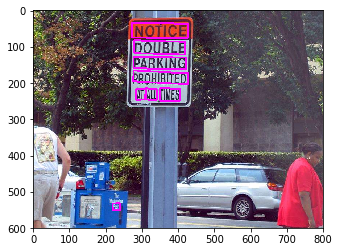

In [2]:
from google.colab import files
# uploaded = files.upload()
import cv2
import numpy as np
import argparse
import time
import math
 
# dummy args for jup notebook
args = {
    "image":"scenetext01.jpg",
    "east": "frozen_east_text_detection.pb",
    "min_confidence":0.25,
    "nms_thresh": 0.24,
    "width":1280,
    "height":640
}

# load the input image and grab the image dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(H, W) = image.shape[:2]
print(H,W)
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (args["width"], args["height"])
rW = W / float(newW)
rH = H / float(newH)
 
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])
 
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
 
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
boxes = []
confidences = []
 
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
  
	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < args["min_confidence"]:
			continue
	
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
 
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
 
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
 
		# compute the rotated rect for
		# the text prediction bounding box
		offset = (offsetX + (cos * xData1[x]) + (sin * xData2[x]),
              offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		p1 = (-sin * h + offset[0], -cos * h + offset[1])
		p3 = (-cos * w + offset[0],  sin * w + offset[1])
		center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))

    # add the bounding box coordinates and probability score to
		# our respective lists
		boxes.append((center, (w,h), angle * 180.0 / math.pi))
		confidences.append(float(scoresData[x]))

# apply non-maxima suppression to suppress weak, overlapping bounding boxes
indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, args["min_confidence"], args["nms_thresh"])


# loop over the bounding boxes
for i in indices:
  # get 4 corners of the rotated rect
  vertices = cv2.boxPoints(boxes[i[0]])

  # scale the bounding box coordinates based on the respective ratios
  for j in [0,1,2,3]:
    vertices[j][0] *= rW
    vertices[j][1] *= rH
#   print('shape: ', vertices.shape)
  # draw the bounding box on the image
  for j in [0,1,2,3]:
    p1 = (vertices[j][0], vertices[j][1])
    p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
    cv2.line(orig, p1, p2, (255, 0, 255), 4);
 
 # show the output image
import matplotlib.pyplot as plt
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(orig)

#cv2.imshow("Text Detection", orig)
#cv2.waitKey(0)
